In [1]:
from event_table import event_table
from plot_event import plot_event
import matplotlib.pyplot as plt

In [2]:
# Issues: getting the right thermostat data -- hsp, csp, IAT not the columns
# some event days dont work
# get the mapping from the MDAL queries
# BASELINE: SCE 10 days before 
# get energy consumed in even vs baseline 
site = 'ciee'
start = '2018-06-01T00:00:00Z'
end = '2018-06-30T00:00:00Z'
event_day = '2018-06-15T00:00:00'
event_start_hour = 14
event_end_hour = 18

tbl = event_table(site, event_day, start, end, 14, 18, max_baseline=True);

2018-06-22 17:00:00-07:00


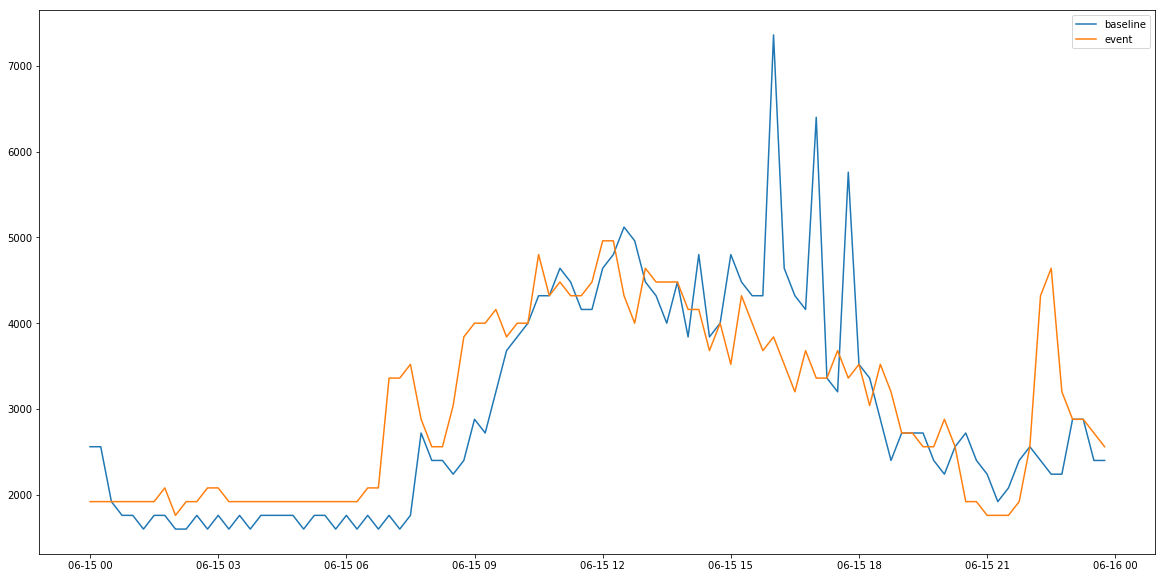

In [3]:
df = tbl['df']
plt.figure(figsize=(20, 10))
plt.plot(df['baseline-demand'], label='baseline')
plt.plot(df['event-demand'], label='event')
plt.legend()

In [4]:
tbl['df'].head()

,baseline-demand,event-demand,baseline-weather,event-weather,baseline-IAT,event-IAT
2018-06-15 00:00:00,2560.0,1920.0,55.940022,53.462753,NaN,76.236628
2018-06-15 00:15:00,2560.0,1920.0,55.869819,53.462753,NaN,76.141104
2018-06-15 00:30:00,1920.0,1920.0,56.450309,53.462753,NaN,76.031496
2018-06-15 00:45:00,1760.0,1920.0,56.730211,53.462753,NaN,75.649845
2018-06-15 01:00:00,1760.0,1920.0,56.544819,54.543647,NaN,75.625000


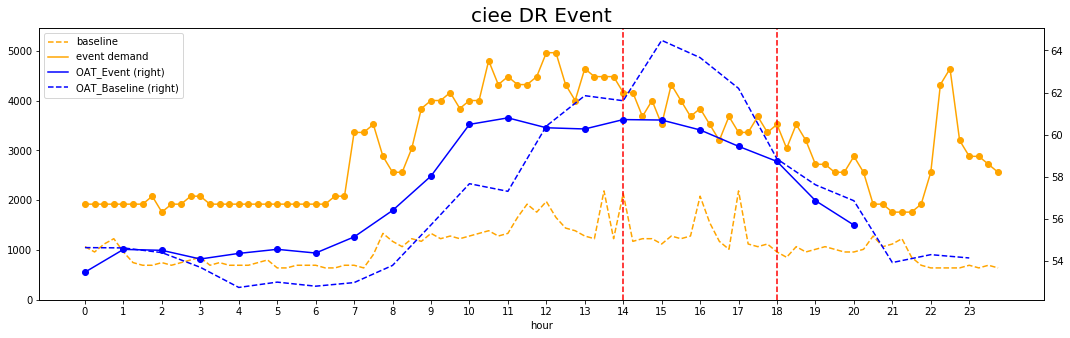

<Figure size 432x288 with 0 Axes>

In [8]:
plot_event(site, event_day, start, end, 14, 18);

In [9]:
from calc_price import *

In [10]:
options =  {
        'utility_id': '14328',
        'sector': 'Commercial',
        'tariff_rate_of_interest': 'A-1 Small General Service', 
        'distrib_level_of_interest': None, #TODO: Figure out what this is
        'phasewing': 'Single',
        'tou': True
    }

In [11]:
power_vector = tbl['df']['event-demand']

In [12]:
calc_total_price(power_vector, tariff_options=options, start_datetime = power_vector.index[0], end_datetime=power_vector.index[-1])

17.018458000000003

In [13]:
tbl['df'].head()

,baseline-demand,event-demand,baseline-weather,event-weather,baseline-IAT,event-IAT
2018-06-15 00:00:00,2080.0,1920.0,54.030203,53.462753,NaN,76.236628
2018-06-15 00:15:00,3520.0,1920.0,53.369595,53.462753,NaN,76.141104
2018-06-15 00:30:00,3040.0,1920.0,53.224713,53.462753,NaN,76.031496
2018-06-15 00:45:00,2720.0,1920.0,53.240000,53.462753,NaN,75.649845
2018-06-15 01:00:00,2720.0,1920.0,53.204910,54.543647,NaN,75.625000


In [14]:
def agg_tbl(table, event_start_hr, event_end_hr, tariff_opts):
    date = str(table.index[0].date())
    energy_baseline = power_15min_to_hourly_energy(table['baseline-demand'])
    energy_event = power_15min_to_hourly_energy(table['event-demand'])
    full_day_baseline = sum(energy_baseline)
    full_day_event = sum(energy_event)
    window_baseline = sum(energy_baseline[(energy_baseline.index >= event_start_hr) & (energy_baseline.index <= event_end_hr)])
    window_event = sum(energy_event[(energy_event.index >= event_start_hr) & (energy_event.index <= event_end_hr)])
    baseline_cost = calc_total_price(table['baseline-demand'], tariff_opts, table['baseline-demand'].index[0], table['baseline-demand'].index[-1])
    event_cost = calc_total_price(table['event-demand'], tariff_opts, table['event-demand'].index[0], table['baseline-demand'].index[-1])
    event_peak_temp = max(table['event-weather'])
    baseline_peak_temp = max(table['baseline-weather'])
    max_demand_baseline = max(table['baseline-demand'])
    max_demand_event = max(table['event-demand'])
    return {
        'date': date,
        'baseline_full': full_day_baseline,
        'event_full': full_day_event,
        'baseline_window': window_baseline,
        'event_window': window_event,
        'baseline_peak_demand': max_demand_baseline,
        'event_peak_demand': max_demand_event,
        'baseline_cost': baseline_cost,
        'event_cost': event_cost,
        'event_peak_temp': event_peak_temp,
        'baseline_peak_temp': baseline_peak_temp
    }
    

In [15]:
agg_tbl(tbl['df'], 14, 18, options)

{'date': '2018-06-15',
 'baseline_full': 71080.0,
 'event_full': 73040.0,
 'baseline_window': 17760.0,
 'event_window': 18200.0,
 'baseline_peak_demand': 4480.0,
 'event_peak_demand': 4960.0,
 'baseline_cost': 16.545866,
 'event_cost': 17.018458000000003,
 'event_peak_temp': 60.79662587890631,
 'baseline_peak_temp': 68.09988220214848}

In [16]:
events = pd.read_json('./pricing/openei_tariff/PDP_events.json')

In [17]:
pge = events[events['utility_id'] == 14328]

In [18]:
pge.head(3)

,end_date,start_date,utility_id
11,2018-06-12T23:00:00-08:00,2018-06-12T00:00:00-08:00,14328
12,2018-06-13T23:00:00-08:00,2018-06-13T00:00:00-08:00,14328
13,2018-07-10T23:00:00-08:00,2018-07-10T00:00:00-08:00,14328


In [19]:
pd.to_datetime(pge.iloc[0, 1]) + pd.to_timedelta(1, unit='day')

Timestamp('2018-06-13 08:00:00')

In [20]:
def add_days(dt, days):
    date_time = (pd.to_datetime(dt) + pd.to_timedelta(days, unit='day')).replace(tzinfo=pytz.timezone('US/Pacific'))
    date_str = str(date_time).replace(' ', 'T')
    lst = list(date_str)
    lst[-6] = 'Z'
    return ''.join(lst[0: -5])

In [21]:
t = add_days(pge.iloc[0, 1], -10)

In [22]:
pge.iloc[0, 1][:-6]

'2018-06-12T00:00:00'

In [23]:
site='ciee'

# tables = pge.apply(lambda r: event_table(site, r['start_date'], add_days(r['start_date'], -11), add_days(r['start_date'], 1))), axis=1

In [24]:
tables = pge.apply(lambda r: event_table(site, r['start_date'][:-6], add_days(r['start_date'], -30), add_days(r['start_date'], 30), max_baseline=True), axis=1)



2018-06-22 01:00:00-07:00
2018-06-22 01:00:00-07:00
2018-06-22 01:00:00-07:00
2018-06-22 01:00:00-07:00
2018-06-22 01:00:00-07:00
2018-06-22 01:00:00-07:00
2018-07-05 01:00:00-07:00
2018-07-05 01:00:00-07:00
2018-07-05 01:00:00-07:00


In [25]:
dfs = [t['df'] for t in tables]

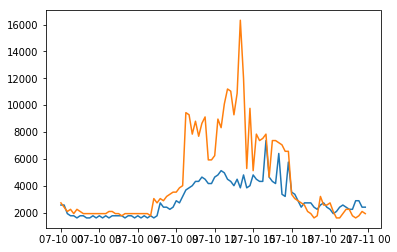

In [33]:
example = dfs[2]
baseline = example['baseline-demand']
event = example['event-demand']
plt.plot(baseline)
plt.plot(event)

In [28]:
ciee_events = [agg_tbl(df, 14, 18, options) for df in dfs]

In [29]:
ciee_events = pd.DataFrame(ciee_events)[[
        'date',
        'baseline_full',
        'event_full',
        'baseline_window',
        'event_window',
        'baseline_peak_demand',
        'event_peak_demand',
        'baseline_cost',
        'event_cost',
        'event_peak_temp',
        'baseline_peak_temp',
    ]]

In [30]:
ciee_events['savings'] = ciee_events['baseline_cost'] - ciee_events['event_cost']

In [31]:
ciee_events

,date,baseline_full,event_full,baseline_window,event_window,baseline_peak_demand,event_peak_demand,baseline_cost,event_cost,event_peak_temp,baseline_peak_temp,savings
0,2018-06-12,71200.0,107200.0,21440.0,32480.0,7360.0,11360.0,27.812342,42.472678,75.375050,71.1851,-14.660336
1,2018-06-13,71200.0,102840.0,21440.0,35760.0,7360.0,15680.0,27.812342,43.718368,74.734700,71.1851,-15.906026
2,2018-07-10,71200.0,104800.0,21440.0,34440.0,7360.0,16320.0,27.812342,44.031210,76.328825,71.1851,-16.218868
3,2018-07-16,71200.0,70640.0,21440.0,17280.0,7360.0,6080.0,27.812342,25.049276,66.845300,71.1851,2.763066
4,2018-07-17,71200.0,78080.0,21440.0,20880.0,7360.0,4960.0,27.812342,28.662868,68.152550,71.1851,-0.850526
5,2018-07-19,71200.0,76280.0,21440.0,21840.0,7360.0,6240.0,27.812342,28.973994,68.270000,71.1851,-1.161652
6,2018-07-24,72920.0,72480.0,19600.0,19400.0,4640.0,4960.0,26.854964,26.754134,69.665000,71.7296,0.100830
7,2018-07-25,72920.0,68160.0,19600.0,19680.0,4640.0,4480.0,26.854964,25.752420,71.484800,71.7296,1.102544
8,2018-07-27,72920.0,63880.0,19600.0,17520.0,4640.0,4320.0,26.854964,23.966564,64.545350,71.7296,2.888400


In [41]:
tables = pge.apply(lambda r: event_table(site, r['start_date'][:-6], add_days(r['start_date'], -30), add_days(r['start_date'], 30)), axis=1)
dfs = [t['df'] for t in tables]
ciee_events = [agg_tbl(df, 14, 18, options) for df in dfs]
ciee_events = pd.DataFrame(ciee_events)[[
        'date',
        'baseline_full',
        'event_full',
        'baseline_window',
        'event_window',
        'baseline_peak_demand',
        'event_peak_demand',
        'baseline_cost',
        'event_cost',
        'event_peak_temp',
        'baseline_peak_temp',
    ]]
ciee_events['savings'] = ciee_events['baseline_cost'] - ciee_events['event_cost']
ciee_events

DatetimeIndex(['2018-06-26', '2018-06-27', '2018-06-28'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-06-27', '2018-06-28', '2018-06-29'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-07-23', '2018-07-26', '2018-07-30'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-08-01', '2018-08-02', '2018-08-03'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-08-02', '2018-08-03', '2018-08-06'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-08-06', '2018-08-07', '2018-08-08'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-08-09', '2018-08-10', '2018-08-13'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-08-10', '2018-08-13', '2018-08-14'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-08-13', '2018-08-14', '2018-08-15'], dtype='datetime64[ns]', name='date', freq=None)


,date,baseline_full,event_full,baseline_window,event_window,baseline_peak_demand,event_peak_demand,baseline_cost,event_cost,event_peak_temp,baseline_peak_temp,savings
0,2018-06-12,0.0,107200.0,0.0,32480.0,0.0,11360.0,0.0,42.472678,75.375050,64.509150,-42.472678
1,2018-06-13,0.0,102840.0,0.0,35760.0,0.0,15680.0,0.0,43.718368,74.734700,64.031225,-43.718368
2,2018-07-10,0.0,104800.0,0.0,34440.0,0.0,16320.0,0.0,44.031210,76.328825,66.252700,-44.031210
3,2018-07-16,0.0,70640.0,0.0,17280.0,0.0,6080.0,0.0,25.049276,66.845300,68.454052,-25.049276
4,2018-07-17,0.0,78080.0,0.0,20880.0,0.0,4960.0,0.0,28.662868,68.152550,70.494898,-28.662868
5,2018-07-19,0.0,76280.0,0.0,21840.0,0.0,6240.0,0.0,28.973994,68.270000,69.333900,-28.973994
6,2018-07-24,0.0,72480.0,0.0,19400.0,0.0,4960.0,0.0,26.754134,69.665000,74.313350,-26.754134
7,2018-07-25,0.0,68160.0,0.0,19680.0,0.0,4480.0,0.0,25.752420,71.484800,67.149163,-25.752420
8,2018-07-27,0.0,63880.0,0.0,17520.0,0.0,4320.0,0.0,23.966564,64.545350,65.538050,-23.966564


In [31]:
import dataclient
m = dataclient.MDALClient("corbusier.cs.berkeley.edu:8088")

In [33]:
start = '2018-05-01T00:00:00Z'
end = '2018-11-01T00:00:00Z'

In [34]:
request = {
    "Variables": {
            "weather": {
                "Definition": """SELECT ?t ?t_uuid FROM %s WHERE {
                    ?t rdf:type/rdfs:subClassOf* brick:Weather_Temperature_Sensor .
                    ?t bf:uuid ?t_uuid
                };""" % site,
            }
    }
}

In [35]:
request['Composition'] = ['weather']
request['Aggregation'] = {'weather': ['MAX']}
request['Time'] = {
    'Start': start,
    'End': end,
    'Window': '24h',
    'Aligned': True
}

In [36]:
esp_weather = m.query(request)

In [39]:
df = esp_weather.df

In [44]:
mean = df.mean(axis=1)

In [62]:
day = mean.sort_values(ascending=False).index[0]

In [61]:
from collect import get_weather_power_tstat

In [69]:
day_after = day + pd.DateOffset(1)

Timestamp('2018-06-23 17:00:00-0700', tz='US/Pacific')

In [89]:
result = get_weather_power_tstat('ciee', str(day.date()) + 'T00:00:00Z', str((day + pd.DateOffset(1)).date()) + 'T00:00:00Z')

In [79]:
str(day.date()) + 'T00:00:00Z'

'2018-06-22T00:00:00Z'

In [80]:
str(day.date()) + 'T00:00:00Z'

'2018-06-22T00:00:00Z'

In [86]:
str(day.date())

'2018-06-22'

In [91]:
result['weather'].df

,00327584-54b2-35a8-aaed-182747a5dda7,a73c1b67-142f-3b45-baf8-e308619b6bbc
2018-06-21 17:00:00-07:00,67.139600,67.999989
2018-06-21 17:15:00-07:00,65.440394,66.920000
2018-06-21 17:30:00-07:00,65.100200,66.920000
2018-06-21 17:45:00-07:00,66.889400,66.920000
2018-06-21 18:00:00-07:00,67.449189,66.920000
2018-06-21 18:15:00-07:00,68.770400,64.940000
2018-06-21 18:30:00-07:00,68.210600,64.940000
2018-06-21 18:45:00-07:00,67.629200,64.940000
2018-06-21 19:00:00-07:00,66.669819,64.940000
2018-06-21 19:15:00-07:00,NaN,62.960000
